In [1]:
# Allow reload of objects
%load_ext autoreload
%autoreload
from pelenet.utils import Utils
from pelenet.experiments.reward import RewardExperiment

# Official modules
import numpy as np
import nxsdk.api.n2a as nx
import matplotlib
import matplotlib.pyplot as plt
from time import time

In [2]:
# Initilizes the experiment and utils
utils = Utils.instance()
exp = RewardExperiment()

In [3]:
# Build network
exp.build()

# Get spectral radius
utils.getSpectralRadius(exp.net.initialWeights)

/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


0.64

In [ ]:
self = exp.net

nExCores = int(np.ceil(self.p.reservoirExSize / self.p.neuronsPerCore))
nInCores = int(np.ceil(self.p.reservoirInSize / self.p.neuronsPerCore))
nAllCores = nExCores + nInCores

compProto = nx.CompartmentPrototype(compartmentVoltageDecay=self.p.compartmentVoltageDecay,
                                    refractoryDelay=self.p.refractoryDelay, logicalCoreId=nAllCores+1)

In [ ]:
"""
Difference neuron
"""

diffCompPlus = self.nxNet.createCompartmentGroup(size=1, prototype=compProto)
diffCompMinus = self.nxNet.createCompartmentGroup(size=1, prototype=compProto)

In [4]:
"""
Add output neuron
"""

outComp = self.nxNet.createCompartmentGroup(size=1, prototype=compProto)

ma = np.ones((1, self.p.reservoirExSize)).astype(int)
we = np.random.normal(1, 5, self.p.reservoirExSize).astype(int)

for i in range(len(self.exReservoirChunks)):
    fr, to = i*self.p.neuronsPerCore, (i+1)*self.p.neuronsPerCore
    self.exReservoirChunks[i].connect(outComp, connectionMask=ma[:,fr:to], weight=we[fr:to], prototype=self.mixedConnProto)

self.outSpikeProbe = outComp.probe([nx.ProbeParameter.SPIKE])[0]

In [42]:
"""
Input generator
"""

sg = self.nxNet.createSpikeGenProcess(numPorts=1)

# Generate spikes
rnd = np.random.rand(self.p.totalSteps)
thresh = (self.p.totalSteps-np.arange(self.p.totalSteps))/self.p.totalSteps
spike = (rnd < thresh)

# Index of every second spike
idxSecSpike = np.where(spike)[0][::2]

# Add spikes to generator
sg.addSpikes(spikeInputPortNodeIds=1, spikeTimes=list(idxSecSpike))

In [ ]:
# Connect input to difference neurons

# Connect output to difference neurons

# Connect difference neurons to reward channel


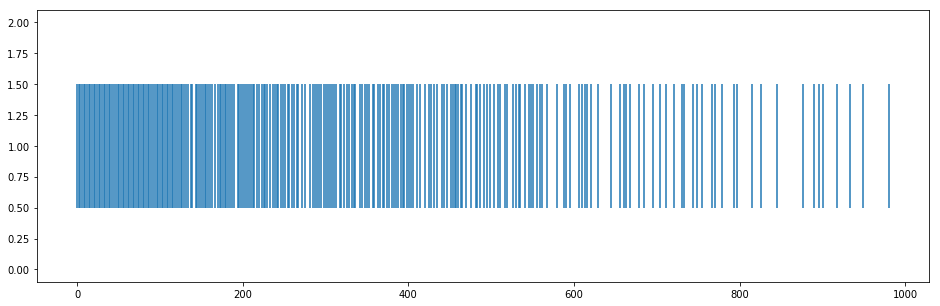

In [39]:
plt.figure(figsize=(16,5))
plt.eventplot(idxSecSpike)

In [5]:
exp.run()

INFO:DRV:  Connecting to 127.0.0.1:35823
INFO:DRV:      Host server up..............Done 0.02s
INFO:DRV:      Encoding axons/synapses.....Done 0.33s
INFO:DRV:      Compiling Embedded snips....Done 0.09s
INFO:HST:  Using Kapoho Bay serial number 308
INFO:HST:  Args chip=0 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1579608722.5616882/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 1.11s
INFO:DRV:      Encoding probes.............Done 0.90ms
INFO:DRV:      Transferring spikes.........Done 2.43ms
INFO:DRV:      Configuring registers.......Done 0.41s
INFO:DRV:      Transferring probes.........Done 6.81ms
INFO:DRV:      Executing...................Done 9.96s
INFO:DRV:      Processing timeseries.......Done 0.08s
INFO:DRV:  Executor: 1000 timesteps........Done 12.03s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


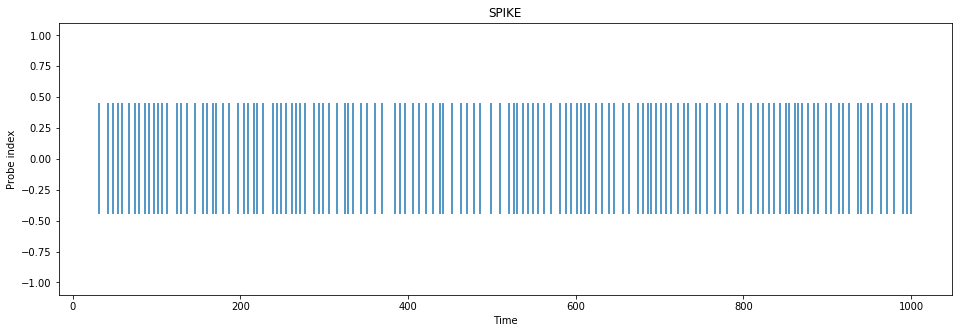

In [6]:
plt.figure(figsize=(16,5))
self.outSpikeProbe.plot()

In [10]:
np.sum(self.outSpikeProbe.data)/1000

0.136

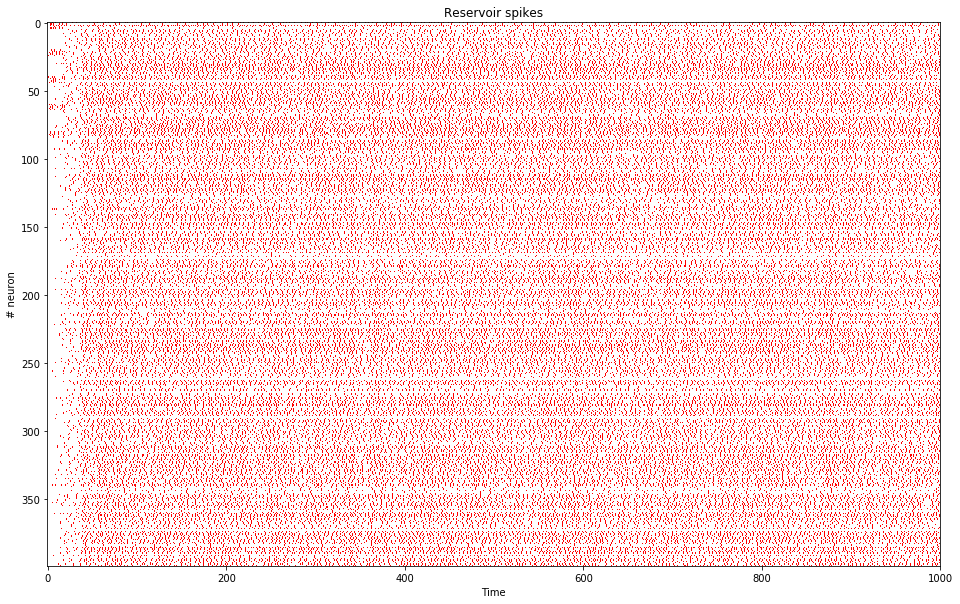

In [8]:
exp.net.plot.reservoirSpikeTrain()

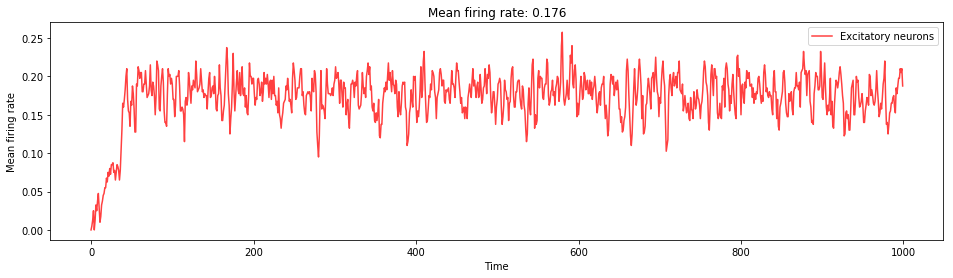

In [9]:
exp.net.plot.reservoirRates()